<a href="https://colab.research.google.com/github/vietnguyen012/FER_embedding_clustering/blob/main/FCM_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Set up environment

- Load data via URL

In [1]:
!gdown https://drive.google.com/uc?id=1OCF_6ZblqfmUjI8spsa85l1JKLXqiQFq
!unzip -q fer2013.zip
!rm fer2013.zip

Downloading...
From: https://drive.google.com/uc?id=1OCF_6ZblqfmUjI8spsa85l1JKLXqiQFq
To: /content/fer2013.zip
63.3MB [00:02, 28.5MB/s]


- Load data via directory

In [ ]:
!unzip /content/drive/MyDrive/fer2013.zip

unzip:  cannot find or open /content/drive/MyDrive/fer2013.zip, /content/drive/MyDrive/fer2013.zip.zip or /content/drive/MyDrive/fer2013.zip.ZIP.


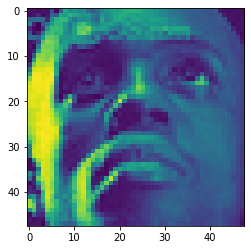

In [1]:
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import torch
from torch.autograd import Variable
from torchvision import datasets, transforms
import numpy as np
import torch.nn as nn
%matplotlib inline
image = Image.open('/content/train/neutral/Training_10002154.jpg')
image = np.asarray(image)/255
plt.imshow(image)

a sample image from dataset

In [2]:
image

array([[0.05490196, 0.05882353, 0.03921569, ..., 0.05098039, 0.0627451 ,
        0.05098039],
       [0.03529412, 0.06666667, 0.1254902 , ..., 0.06666667, 0.05098039,
        0.05490196],
       [0.32941176, 0.34509804, 0.36862745, ..., 0.05882353, 0.05098039,
        0.0627451 ],
       ...,
       [0.04313725, 0.32156863, 0.14117647, ..., 0.19607843, 0.16862745,
        0.10196078],
       [0.07058824, 0.04313725, 0.0627451 , ..., 0.16862745, 0.14117647,
        0.0745098 ],
       [0.05490196, 0.05882353, 0.07843137, ..., 0.15686275, 0.1372549 ,
        0.04705882]])

In [23]:

transform = transforms.Compose([transforms.Grayscale(),
                                    transforms.Resize((128,128),interpolation=Image.NEAREST),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,),(0.5,))])

data = datasets.ImageFolder('/content/train', transform=transform)
data_test = datasets.ImageFolder('/content/test', transform=transform)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


total samples of training data

In [4]:
len(data)

28709

In [5]:
data.class_to_idx

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [24]:
from torch.utils.data import DataLoader
data_loader = DataLoader(data, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(data_test, batch_size=32, shuffle=True, num_workers=2)

In [7]:
it = iter(data_loader)
first_batch = next(it)
first_batch[0].size(),first_batch[1].size()

(torch.Size([32, 1, 128, 128]), torch.Size([32]))

given mean and standard deviation of the distribution, we used random sample to 
sample a tensor from the distribution

# III. FCM


this kl-divergence (22) uses membership matrix qij to approximate student's-t Distribution pij in DEC,IDEC structures


$$
\Large \min KL(P||Q) = \min \sum_{i=1}^N \sum_{j=1}^c p_{ij}\log\frac{p_{ij}}{q_{ij}} \qquad (22)
$$ 

In [8]:
loss_kl = nn.KLDivLoss(size_average=False)
def KL_divergence(p,q):  
  return loss_kl(q.log(), p) / q.shape[0]

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


The desired target pij of the Student’s-t based membership qij
is defined with (12), which increases the variance of qij and
normalizes qij with respect of the jth center .

$$
\Large p_{ij} = \frac{q_{ij}^2 / \sum_{i}q_{ij}}
{\sum_{k=1}^{c}(q_{ik}^2 / \sum_{i}q_{ik})}, 
\quad \sum_{j=1}^{c}p_{ij} = 1, \, \forall{i} \qquad (12)
$$ 

In [9]:
def calculate_p(q):
  w = (q**2/torch.sum(q,0))
  return (w.t()/torch.sum(w,1).t()).t()

Minimzing Fuzzy cluster compactness equivalent to minimize within class scatter matrix and maximize between class matrix.From this objective, fuzzy membership qij is given by (21)

$$
\Large q_{ij} = \frac{(\|z_{i} - \mu_{j}\|^2 - \frac{\beta}{\sum_{k=1}^{c}\|\mu_{k} - \overline{\mu}\|^2}\|\mu_{j} - \overline{\mu}\|^2)^{-1/(m-1)}}
{\sum_{k=1}^{c}(\|z_{i} - \mu_{k}\|^2 - \frac{\beta}{\sum_{k=1}^{c}\|\mu_{k} - \overline{\mu}\|^2}\|\mu_{k} - \overline{\mu}\|^2)^{-1/(m-1)}} \qquad (21)
$$ 

In [10]:
class ClusterAssigment(nn.Module):
  def __init__(self,cluster_number,cluster_center,embedding_dimension):
    super(ClusterAssigment,self).__init__()  
    self.cluster_number = cluster_number
    self.embedding_dimension = embedding_dimension
    if cluster_center is None:
      initial_cluster_center = torch.zeros(cluster_number,embedding_dimension,dtype=torch.float).to('cuda')
      nn.init.xavier_uniform_(initial_cluster_center)
    else:
      initial_cluster_center = cluster_center
    self.cluster_center = nn.Parameter(initial_cluster_center,requires_grad=True).to('cuda') 
  def forward(self,z):
    batch_size,embedding_dimension = z.size() 
    beta = 0.006
    m = 1.5
    power = -1/(m-1)
    norm_squared = torch.sum((z.unsqueeze(1)-self.cluster_center)**2,2)
    norm_squared_mu = torch.sum((self.cluster_center - self.cluster_center.mean())**2,1)
    numerator = (norm_squared-beta/torch.sum(norm_squared_mu)*norm_squared_mu)**power
    q = numerator/torch.sum(numerator,dim=1,keepdim=True)
    return q

Define label li,lv are pseudo labels of the maximum value's index of the datapoint with coresponding the C cluster, taking datapoints zi,zv we calculate the affinity between the datapoints when it has the same pseudo-labels or 0 otherwise

$$
\Large s_{iv} = 
\begin{cases} 
  \exp(-\|z_{i} - z_{v}\|^2 / \sigma) / t, \quad l_i = l_v
  \\\\
  0, \quad l_i \ne l_v
\end{cases}
\qquad (28)
$$

In [11]:
def repeat(tensor, dims):
    if len(dims) != len(tensor.shape):
        raise ValueError("The length of the second argument must equal the number of dimensions of the first.")
    for index, dim in enumerate(dims):
        repetition_vector = [1]*(len(dims)+1)
        repetition_vector[index+1] = dim
        new_tensor_shape = list(tensor.shape)
        new_tensor_shape[index] *= dim
        tensor = tensor.unsqueeze(index+1).repeat(repetition_vector).reshape(new_tensor_shape)
    return tensor

In [12]:
def calculate_affinity(q,z):
  batch,_ = q.size()
  s_iv = torch.zeros(batch,batch).to(z.device)
  labels = torch.argmax(q,axis=1)
  sigma = 1
  t = 0.08
  x = (labels == labels.unsqueeze(1)).nonzero(as_tuple=True)
  s_iv[x] = torch.exp(-torch.linalg.norm(z[x[0]] - z[x[1]], axis=1)**2/sigma)/t
  return s_iv,labels


Graph based regularization on hidden features with the assumption that the input data should be consistent with the ones in new representation (for example Z-representation). If the affinity of xi and xv is high then the distance between zi and zv must be low, on the other hand, if affinity of xi and xv is low like zero then the distance between zi and zv can be large . 

$$
\Large \min G_z = \min \sum_{i,v=1}^{N} \|z_i - z_v\|^{2} s_{iv}
$$

In [13]:
def graph_based_reg(q,z,s_iv,calculate_siv):
  batch,_ = q.size()
  if calculate_siv:
      s_iv,pseudo_label =  calculate_affinity(q,z)
  else:
      pseudo_label=torch.argmax(q,axis=1)
  z_i = repeat(z,[batch,1])
  z_v = torch.tile(z, (batch,1))
  l_graph_based_reg = torch.sum(torch.linalg.norm(z_i-z_v,dim=1)*s_iv.flatten())
  return l_graph_based_reg, s_iv,pseudo_label

# IV. Define and Train Model

The architecture of autoecnoder

In [14]:
class VAE(nn.Module):
    def __init__(self, nc, ngf, ndf, latent_variable_size):
        super(VAE, self).__init__()
        self.nc = nc
        self.ngf = ngf
        self.ndf = ndf
        self.latent_variable_size = latent_variable_size

        # encoder
        self.e1 = nn.Conv2d(nc, ndf, 4, 2, 1)
        self.bn1 = nn.BatchNorm2d(ndf)

        self.e2 = nn.Conv2d(ndf, ndf*2, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(ndf*2)

        self.e3 = nn.Conv2d(ndf*2, ndf*4, 4, 2, 1)
        self.bn3 = nn.BatchNorm2d(ndf*4)

        self.e4 = nn.Conv2d(ndf*4, ndf*8, 4, 2, 1)
        self.bn4 = nn.BatchNorm2d(ndf*8)

        self.e5 = nn.Conv2d(ndf*8, ndf*8, 4, 2, 1)
        self.bn5 = nn.BatchNorm2d(ndf*8)

        self.fc1 = nn.Linear(ndf*8*4*4, latent_variable_size)
        self.fc2 = nn.Linear(ndf*8*4*4, latent_variable_size)

        # decoder
        self.d1 = nn.Linear(latent_variable_size, ngf*8*2*4*4)

        self.up1 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd1 = nn.ReplicationPad2d(1)
        self.d2 = nn.Conv2d(ngf*8*2, ngf*8, 3, 1)
        self.bn6 = nn.BatchNorm2d(ngf*8, 1.e-3)

        self.up2 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd2 = nn.ReplicationPad2d(1)
        self.d3 = nn.Conv2d(ngf*8, ngf*4, 3, 1)
        self.bn7 = nn.BatchNorm2d(ngf*4, 1.e-3)

        self.up3 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd3 = nn.ReplicationPad2d(1)
        self.d4 = nn.Conv2d(ngf*4, ngf*2, 3, 1)
        self.bn8 = nn.BatchNorm2d(ngf*2, 1.e-3)

        self.up4 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd4 = nn.ReplicationPad2d(1)
        self.d5 = nn.Conv2d(ngf*2, ngf, 3, 1)
        self.bn9 = nn.BatchNorm2d(ngf, 1.e-3)

        self.up5 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd5 = nn.ReplicationPad2d(1)
        self.d6 = nn.Conv2d(ngf, nc, 3, 1)

        self.leakyrelu = nn.LeakyReLU(0.2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()


        self.log_scale = nn.Parameter(torch.Tensor([0.0]))
        self.assigment = ClusterAssigment(7,None,500)

    def encode(self, x):
        h1 = self.leakyrelu(self.bn1(self.e1(x)))
        h2 = self.leakyrelu(self.bn2(self.e2(h1)))
        h3 = self.leakyrelu(self.bn3(self.e3(h2)))
        h4 = self.leakyrelu(self.bn4(self.e4(h3)))
        h5 = self.leakyrelu(self.bn5(self.e5(h4)))
        h5 = h5.view(-1,self.ndf*8*4*4)

        return self.fc1(h5), self.fc2(h5)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.FloatTensor(std.size()).normal_().to('cuda')
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h1 = self.relu(self.d1(z))
        h1 = h1.view(-1, self.ngf*8*2, 4, 4)
        h2 = self.leakyrelu(self.bn6(self.d2(self.pd1(self.up1(h1)))))
        h3 = self.leakyrelu(self.bn7(self.d3(self.pd2(self.up2(h2)))))
        h4 = self.leakyrelu(self.bn8(self.d4(self.pd3(self.up3(h3)))))
        h5 = self.leakyrelu(self.bn9(self.d5(self.pd4(self.up4(h4)))))
        return self.sigmoid(self.d6(self.pd5(self.up5(h5))))

    def get_latent_var(self, x):
        mu, logvar = self.encode(x.view(-1, self.nc, self.ndf, self.ngf))
        z,_ = self.reparametrize(mu, logvar)
        return z

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.nc, self.ndf, self.ngf))
        kl_loss = 0.5*torch.sum(-1-logvar+mu**2+torch.exp(logvar))
        z = self.reparametrize(mu, logvar)
        q = self.assigment(z)
        res = self.decode(z)
        crit = nn.BCELoss()
        llh_loss = crit(res, x)
        var_loss = (llh_loss+kl_loss)
        return z,q,var_loss


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
vae = VAE(nc=1, ngf=128, ndf=128, latent_variable_size=500).to('cuda')
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4, betas=(0.9, 0.999))

cuda:0


Algorithm 1: the algorithm for graph regularized deep normalized fuzzy compactness separation clustering 

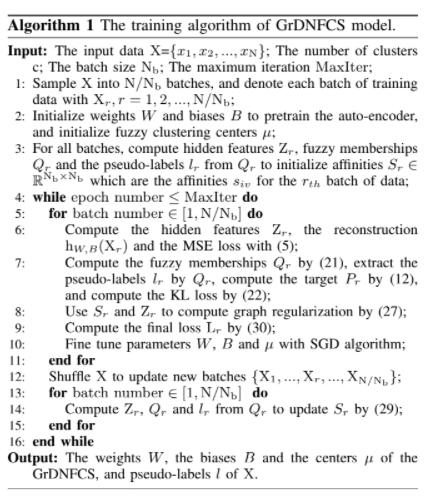

In [16]:
plt.rcParams["figure.figsize"] = (16, 8)

from torchvision.utils import make_grid
from tqdm import tqdm
import time
num_class=7
alpha1 = 0.5
alpha2 = 0.2
batch=32

prediction_n_ground = []
S = []


Pre-train autencoder

In [18]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.axis('off')
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
for epoch in range(2):
     print(f"Epoch {epoch}")
     time.sleep(0.5)
     loss_mean=0
     count=0
     for images,r in tqdm(data_loader,position=0, leave=True): 
         optimizer.zero_grad() # Clear out the gradients
         images = images.to(device)
         z,q,var_loss = vae(images)
         loss_mean+=var_loss.item()
         count+=1
         var_loss.backward()
         optimizer.step()
     print('mean loss:',loss_mean/count) 

Epoch 0


100%|██████████| 898/898 [06:51<00:00,  2.18it/s]


2.004916259799078
Epoch 1


100%|██████████| 898/898 [06:56<00:00,  2.16it/s]

5.896000193427825


In [19]:
features=[]
from sklearn.cluster import KMeans
kmeans = KMeans(7, n_init=20)
for r,(images,_) in enumerate(tqdm(data_loader,position=0,leave=True)): 
  images = images.to(device)
  z,q,var_loss = vae(images)
  features.append(z.detach().cpu())

predicted = kmeans.fit_predict(torch.cat(features).numpy())
cluster_centers = torch.tensor(kmeans.cluster_centers_,dtype=torch.float,requires_grad=True).to(device)

with torch.no_grad():
   vae.assigment.cluster_center.copy_(cluster_centers)

100%|██████████| 898/898 [02:14<00:00,  6.70it/s]


Initilize parameters

In [20]:
#step 3 initialize
device ='cuda'
for images,_ in tqdm(data_loader,position=0,leave=True): 
      vae.eval()
      s_iv = torch.zeros((batch,batch))
      with torch.no_grad():
          optimizer.zero_grad() # Clear out the gradients
          images = images.to(device)
          z,q,var_loss = vae(images)
          _,s_iv,p_label = graph_based_reg(q,z,s_iv,True)
          S.append(s_iv)

100%|██████████| 898/898 [02:14<00:00,  6.68it/s]


In [21]:
from itertools import permutations
def remap_labels(pred_labels,true_labels):
    pred_labels,true_labels = np.array(pred_labels),np.array(true_labels)
    assert pred_labels.ndim == true_labels.ndim == 1
    assert len(pred_labels) == len(true_labels)
    cluster_names = np.unique(pred_labels)
    accuracy = 0

    perms = np.array(list(permutations(np.unique(true_labels))))

    remapped_labels = true_labels
    for perm in perms:
        flipped_labels = np.zeros(len(true_labels))
        for label_index,label in enumerate(cluster_names):
            flipped_labels[pred_labels == label] = perm[label_index]

        testAcc = np.sum(flipped_labels == true_labels) / len(true_labels)
        if testAcc > accuracy:
            accuracy = testAcc
            remapped_labels = flipped_labels
    return accuracy,remapped_labels

Train the whole model

In [29]:
torch.autograd.set_detect_anomaly(True)
#step 4 train
alpha1 = 0.5
alpha2 = 0.8
for epoch in range(5):
    print(f"Epoch {epoch}")
    time.sleep(0.5)
    loss_mean=0
    for r,(images,_) in enumerate(tqdm(data_loader,position=0,leave=True)): 
        optimizer.zero_grad() # Clear out the gradients
        S_r= S[r].to(device).to('cuda')
        images = images.to(device)
        z,q,var_loss = vae(images)
        p = calculate_p(q)
        loss_graph_based_reg,_,_ = graph_based_reg(q,z,S_r,False)
        kl = KL_divergence(p,q)
 
        loss = var_loss + alpha1*kl + alpha2*loss_graph_based_reg 
        loss_mean+=loss.item()
        loss.backward()
        optimizer.step()
    print('mean loss:',loss_mean/r)
    preds = []
    gts = []
    vae.eval()
    for r,(images,ground_truth) in enumerate(tqdm(data_loader,position=0,leave=True)):
        optimizer.zero_grad()
        images = images.to(device)
        z,q,var_loss = vae(images)
        _,s_iv,p_label = graph_based_reg(q,z,S[r].to(device),True)
        S[r]= s_iv.detach().clone()
        preds.append(p_label.squeeze(0).detach().cpu())
        gts.append(ground_truth.squeeze(0).detach().cpu())
    prediction = torch.cat(preds).numpy()
    g_truth = torch.cat(gts).numpy()
    acc = remap_labels(prediction,g_truth)
    print('accuracy:',acc)
    
    #test
    test_pred = []
    test_gt = []
    for r,(images,ground_truth) in enumerate(tqdm(test_loader,position=0,leave=True)):
        optimizer.zero_grad()
        images = images.to(device)
        _,q,_ = vae(images)
        prediction_test = torch.argmax(q,axis=1)
        test_pred.append(prediction_test.squeeze(0).detach().cpu())
        test_gt.append(ground_truth.squeeze(0).detach().cpu())
    test_pred = torch.cat(test_pred).numpy()
    test_gt = torch.cat(test_gt).numpy()
    acc = remap_labels(test_pred,test_gt)
    print('accuracy:',acc)

Epoch 0


  0%|          | 0/898 [00:00<?, ?it/s]

mean loss: -3.4800017614438277


  0%|          | 0/225 [00:00<?, ?it/s]

accuracy: (0.2021665679751994, array([2., 4., 3., ..., 4., 3., 3.]))


100%|██████████| 225/225 [00:34<00:00,  6.55it/s]


accuracy: (0.2031206464196155, array([5., 0., 0., ..., 3., 6., 3.]))
Epoch 1


  0%|          | 0/898 [00:00<?, ?it/s]

mean loss: -3.457549235219221


  0%|          | 0/225 [00:00<?, ?it/s]

accuracy: (0.20551046710090912, array([4., 4., 3., ..., 4., 3., 3.]))


100%|██████████| 225/225 [00:34<00:00,  6.56it/s]


accuracy: (0.20367790470883254, array([5., 5., 5., ..., 5., 5., 3.]))
Epoch 2


  0%|          | 0/898 [00:00<?, ?it/s]

mean loss: -3.541182879827306


  0%|          | 0/225 [00:00<?, ?it/s]

accuracy: (0.21115329687554427, array([4., 3., 4., ..., 4., 3., 4.]))


100%|██████████| 225/225 [00:34<00:00,  6.56it/s]


accuracy: (0.2095291167456116, array([3., 4., 3., ..., 4., 4., 3.]))
Epoch 3


  0%|          | 0/898 [00:00<?, ?it/s]

mean loss: -3.5588028927249553


  0%|          | 0/225 [00:00<?, ?it/s]

accuracy: (0.21439269915357553, array([3., 5., 3., ..., 3., 5., 3.]))


100%|██████████| 225/225 [00:34<00:00,  6.57it/s]


accuracy: (0.224575090554472, array([4., 4., 3., ..., 3., 3., 3.]))
Epoch 4


  0%|          | 0/898 [00:00<?, ?it/s]

mean loss: -3.5791299575198714


  0%|          | 0/225 [00:00<?, ?it/s]

accuracy: (0.2142882023058971, array([5., 3., 0., ..., 4., 3., 4.]))


100%|██████████| 225/225 [00:34<00:00,  6.56it/s]


accuracy: (0.2106436333240457, array([3., 3., 3., ..., 3., 4., 5.]))


In [ ]:
torch.save(ae.state_dict(),'/content/ae.pth')